In [1]:
# Import the dependencies
import os
from dotenv import load_dotenv
from pymongo import MongoClient
import pymongoarrow as pma
from pymongoarrow.api import write
import pandas as pd
import numpy as np
from functools import reduce
from itertools import combinations
import time

from joblib import Parallel, delayed
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform

from sklearn.datasets import make_blobs, make_classification
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import davies_bouldin_score, mutual_info_score, silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MaxAbsScaler

import hvplot.pandas
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import plotly.express as px
from pandas.plotting import scatter_matrix
import seaborn as sns
import umap
import umap.plot
from ydata_profiling import ProfileReport

# Suppress YData profile report generation warnings - no actual problems to resolve.
from warnings import simplefilter 
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

C:\Users\AZ\anaconda3\envs\py3.11\Lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


## Create a test dataset

In [2]:
X, y = make_classification(n_samples=6000, n_features=100, n_informative=10, n_redundant=40, n_repeated=10, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=42) 

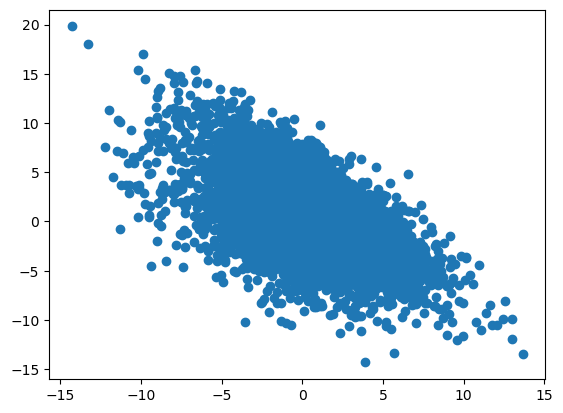

In [3]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [4]:
test_df = pd.DataFrame(X)
test_df = test_df.add_prefix('feature_')
test_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99
0,-2.972924,1.542137,0.535239,-0.138543,-0.393846,0.519546,1.792088,-1.031119,-4.013871,0.642677,...,0.322206,1.542137,-0.161476,-1.266777,-1.054261,2.666127,-1.095090,0.710659,-1.215720,0.557419
1,0.128875,-2.993035,-0.913679,-1.159935,4.959414,1.008542,3.349579,-0.879875,-4.579034,-1.208647,...,0.929755,-2.993035,-0.486745,1.561569,-7.113541,4.486705,0.582151,-0.510650,3.537682,-1.203853
2,8.290328,-2.304549,0.738448,3.855261,-4.939975,-1.901499,-5.919792,-4.251675,-0.512355,-0.337892,...,0.242131,-2.304549,-1.638047,-3.566324,-7.747251,4.719554,-0.762533,-0.213919,-0.145339,-3.664762
3,-1.359076,-0.153997,-1.208975,3.142342,-0.773797,-0.974547,-1.143064,2.080655,0.300853,0.132154,...,1.784115,-0.153997,2.097060,0.206282,5.561700,-1.165566,1.122468,0.157980,-1.574348,0.133666
4,-6.153643,1.699285,-2.500749,-0.011184,-3.153854,0.767623,4.427928,4.116379,-2.793987,0.659878,...,-0.147217,1.699285,0.792091,0.172426,7.736178,0.910275,3.642484,1.519165,0.720257,-0.921282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2.888185,5.885981,-1.239498,2.906579,-7.871516,-1.732345,-8.051165,-4.763704,4.498008,-0.145656,...,0.362209,5.885981,-0.785011,-1.871117,5.406371,-5.366488,-2.503550,-0.323097,-2.380608,3.609860
5996,0.488254,1.431963,2.088272,-0.437393,-6.289868,0.598785,0.025359,2.518417,-1.930433,-1.813690,...,-0.429886,1.431963,0.855706,-2.716225,-2.584077,-1.574551,-0.138212,-1.646225,3.069738,-2.498920
5997,7.131492,-2.387960,-0.737544,1.162545,-5.716671,-0.925627,-0.879556,-2.373835,2.041081,1.715771,...,0.257816,-2.387960,0.131515,-4.240569,-0.629009,2.342131,0.367067,-0.208158,-0.271250,4.429375
5998,3.550531,1.748189,-1.240778,-6.160291,-2.595289,0.151752,0.126496,-0.473655,2.458278,-0.734778,...,-1.454465,1.748189,1.321652,0.258471,-11.006410,-0.705040,-1.320603,0.675177,4.399251,-3.383068


## Principal Feature Analysis ##

#### Define functions to select dataset features that provide relevant information for clustering. 
##### Only important features are used to compute clusters from the complete (non-pca) dataset.

In [5]:
# Initialize global variables for accumulation
clusters_list = []
cluster_criteria_list = []

In [6]:
# Function that defines the clustering algorithm for the subsequent processing
def apply_clustering_algorithm(df, clustering_algorithm, **params):
    print(' Entered apply_clustering_algorithm ')
    if clustering_algorithm == 'kmedoids':
        model = KMedoids(**params)
    elif clustering_algorithm == 'hdbscan':
        model = HDBSCAN(**params)
    else:
        raise ValueError("Unsupported clustering algorithm")

    model.fit(df)
    return model.labels_

In [7]:
# Function: Silhouette Coefficient Calculation
def calculate_silhouette(X, labels):
    print('   Entered calculate_silhouette ')
    if len(np.unique(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return 0

In [8]:
# Function: Scatter Separability Calculation
def calculate_scatter_separability(X, labels):
    print(' Entered calculate_scatter_separability ')
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    n_features = X.shape[1]
    overall_mean = np.mean(X, axis=0)

    # Initialize within-class and between-class scatter matrices
    S_w = np.zeros((n_features, n_features))
    S_b = np.zeros((n_features, n_features))

    for label in unique_labels:
        X_k = X[labels == label]
        mean_k = np.mean(X_k, axis=0).values.reshape(n_features, 1) # Convert to NumPy array and reshape
        # Within-cluster scatter for cluster k
        S_w += (X_k - mean_k.T).T @ (X_k - mean_k.T)
        # Between-cluster scatter for cluster k
        mean_diff = (mean_k - overall_mean.values.reshape(n_features, 1)) # Convert to NumPy array and reshape
        S_b += X_k.shape[0] * (mean_diff @ mean_diff.T)

    # Compute the scatter separability criterion - the trace of the inverse of S_w times S_b, and return the result.
    final_ssc = np.trace(np.linalg.pinv(S_w) @ S_b)
    print(f'   Scatter separability criterion value = {final_ssc}')
    return final_ssc

In [9]:
# Function to accumulate cluster information
def accumulate_cluster_data(clusters, cluster_criteria):
    print(' Entered accumulate_cluster_data ')
    """
    Accumulates cluster information for cross-projection normalization.

    Args:
        clusters: A list of clusters from the current iteration.
        cluster_criteria: A list of cluster criteria (scatter separability or silhouette scores) for the current iteration.

    Returns:
        A tuple of (clusters_list, cluster_criteria_list) for cross-projection normalization.
    """

    global clusters_list, cluster_criteria_list

    clusters_list.append(clusters)
    cluster_criteria_list.append(cluster_criteria)

    print(' Returning clusters_list and cluster_criteria_list')
    return clusters_list, cluster_criteria_list

In [10]:
# Function: Normalization of criterion values with respect to dimension
def cross_projection_normalization(clusters_list, cluster_criteria_list, original_data):
    """
    Normalizes cluster criteria using cross-projection, assuming clusters are NumPy arrays of labels.

    Args:
        clusters_list: A list of lists of cluster labels.
        cluster_criteria_list: A list of cluster criteria to be normalized.
        original_data: The original data used for clustering.

    Returns:
        A list of normalized cluster criteria.
    """

    normalized_criteria = []
    for i, criteria in enumerate(cluster_criteria_list):
        # Calculate pairwise projections for each cluster
        projections = np.zeros((len(clusters_list), len(clusters_list)))

        print(f' i = {i}')
        print(f' criteria = {criteria}')
        print(f' projections shape = {projections.shape}')
        print(f' projections = {projections}')
        print(f' clusters_list = {clusters_list}')
        print(f' cluster_criteria_list = {cluster_criteria_list}')
        
        for j in range(len(clusters_list)):
            for k in range(len(clusters_list)):
                # Access data for clusters based on labels
                cluster_data_j = original_data[clusters_list[j] == clusters_list[j][0]]  # Use the first label as a reference
                cluster_data_k = original_data[clusters_list[k] == clusters_list[k][0]]
                print(f' cluster data j = {cluster_data_j}')
                print(f' cluster data k = {cluster_data_k}')
                projections[j][k] = np.mean([
                    np.linalg.norm(np.mean(cluster_data_j[cluster_data_j == label], axis=0) -
                                   np.mean(cluster_data_k[cluster_data_k == label], axis=0))
                    for label in np.unique(clusters_list[j])
                ])
                print(f' projections[j][k] = {projections[j][k]}')

        # Normalize criteria using the projections
        normalized_criteria.append([
            criteria[i] / (projections[i][i] + projections[j][j] - 2 * projections[i][j])
            for j in range(len(clusters_list))
        ])
        
    print(f' Exiting cross_projection_normalization :: Normalized criteria: {normalized_criteria}')
    return normalized_criteria

In [11]:
# Helper function for Sequential Forward Search
def evaluate_feature_subset(current_subset, df, clustering_algorithm, clustering_params):
    print(' Entered evaluate_feature_subset')
    current_df = df[current_subset]
    cluster_labels = apply_clustering_algorithm(current_df, clustering_algorithm, **clustering_params)

    # Calculate silhouette and scatter separability scores
    scatter_separability = calculate_scatter_separability(current_df, cluster_labels)
    silhouette_score = calculate_silhouette(current_df, current_labels)
    
    # Accumulate cluster information
    clusters_list, cluster_criteria_list = accumulate_cluster_data(current_labels, [scatter_separability, silhouette_score])

    # Normalize values
    normalized_criteria = cross_projection_normalization(clusters_list, cluster_criteria_list, current_df)
    print(f' Normalized criteria: {normalized_criteria}')
    
    # Calculate combined score for subset evaluation
    #combined_score = normalized_silhouette_score + normalized_scatter_separability
    combined_score = normalized_criteria
    return combined_score, current_subset

In [12]:
# Sequential Forward Search - Feature Selection
def sequential_forward_selection(df, clustering_algorithm, clustering_params, n_jobs=-1):
    print('Entered sequential_forward_selection')
    best_features = []
    best_score = -np.inf
    candidate_features = list(df.columns)
    best_cluster_labels = None

    while candidate_features:
        print(f' Number of Candidate Features = {len(candidate_features)}')
        print(f' Number of Best Features = {len(best_features)}')
        
        results = Parallel(n_jobs=n_jobs)(delayed(evaluate_feature_subset)(best_features + [feature], df, clustering_algorithm, clustering_params) for feature in candidate_features)

        # Find the best feature addition
        scores, subsets = zip(*results)
        best_feature_idx = np.argmax(scores)
        if scores[best_feature_idx] > best_score:
            best_score = scores[best_feature_idx]
            best_feature_addition = subsets[best_feature_idx][-1]
            best_cluster_labels = apply_clustering_algorithm(df[best_features + [best_feature_addition]], clustering_algorithm, **clustering_params)
            best_features.append(best_feature_addition)
            candidate_features.remove(best_feature_addition)
        else:
            break

    return best_features, best_cluster_labels


In [13]:
# Function for merging similar k-medoid clusters to reduce the cluster count
def merge_clusters_kmedoids(df, current_k, current_medoids):
    print(' Entered merge_clusters_kmedoids ')
    if current_k == 2:
        print(' Returning current medoids ')
        return current_medoids

    # Extract the medoid points from the dataframe
    medoid_points = df.iloc[current_medoids].values

    # Calculate distances between all medoids
    distance_matrix = np.zeros((len(medoid_points), len(medoid_points)))
    for i in range(len(medoid_points)):
        for j in range(len(medoid_points)):
            distance_matrix[i, j] = np.linalg.norm(medoid_points[i] - medoid_points[j])

    # Set diagonal to infinity to avoid self-merging
    np.fill_diagonal(distance_matrix, np.inf)

    # Find the pair of closest medoids
    i, j = np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)

    # Remove one of the medoids
    new_medoids = np.delete(current_medoids, j, axis=0)

    # Re-run K-Medoids with one less cluster
    kmedoids = KMedoids(n_clusters=current_k-1, init='k-medoids++')
    kmedoids.fit(df)
    
    print(' Returning medoid indicies ')
    return kmedoids.medoid_indices_


In [14]:
# Function that adjusts HDBSCAN parameters to encourage a smaller number of clusters
def merge_clusters_hdbscan(df, current_params):
    print(' Entered merge_clusters_hdbscan ')
    # Increase min_cluster_size or min_samples to potentially reduce the number of clusters
    current_params['min_cluster_size'] += 1
    current_params['min_samples'] += 1

    mcs = current_params['min_cluster_size']
    ms = current_params['min_samples']
    print(f'  Min Cluster Size Param = {mcs}')
    print(f'  Min Samples Param = {ms}')
    
    # Re-run HDBSCAN with updated parameters
    clusterer = hdbscan.HDBSCAN(**current_params)
    clusterer.fit(df)

    return clusterer.labels_

In [15]:
def find_optimal_clusters(df, clustering_algorithm, clustering_params, max_k, calculate_criteria):
    print(' Entered find_optimal_clusters ')
    best_k = max_k
    best_criteria_value = -np.inf
    best_features = []
    best_cluster_labels = None

    current_medoids = None  # Only used for K-Medoids

    while best_k > 2:
        print(f'  Best k = {best_k}')
        if clustering_algorithm == 'kmedoids':
            # Adjust the 'init' parameter based on current_medoids
            kmedoids_params = clustering_params.copy()
            clustering_instance = KMedoids(**kmedoids_params)
        elif clustering_algorithm == 'hdbscan':
            clustering_instance = HDBSCAN(**clustering_params)
        else:
            raise ValueError("Unsupported clustering algorithm")

        current_labels = clustering_instance.fit_predict(df)

        print(' Calculate criteria values for current cluster configuration ')
        # Calculate criteria values for current cluster configuration
        scatter_separability = calculate_scatter_separability(df, current_labels)
        silhouette_score = calculate_silhouette(df, current_labels)
         # Accumulate cluster information
        clusters_list, cluster_criteria_list = accumulate_cluster_data(current_labels, [scatter_separability, silhouette_score])

        # Normalize measures
        normalized_criteria = cross_projection_normalization(clusters_list, cluster_criteria_list, df)

        print(f' length of normalized criteria = {len(normalized_criteria)}')
        summed_value = 0
        
        for criteria_set in normalized_criteria:
            summed_value += sum(criteria_set)

        print(f' Summed Value of normalized criteria = {summed_value}')

        if summed_value > best_criteria_value:
            best_criteria_value = summed_value
            best_cluster_labels = current_labels
            print(f' Calling sequentiol forward selection function ')
            best_features, _ = sequential_forward_selection(df, clustering_algorithm, clustering_params)
            if clustering_algorithm == 'kmedoids':
                current_medoids = clustering_instance.medoid_indices_
        else:
            best_k -= 1
            if clustering_algorithm == 'kmedoids':
                print(' Calling merge_clusters_kmedoids ')
                current_medoids = merge_clusters_kmedoids(df, best_k, current_medoids)
            elif clustering_algorithm == 'hdbscan':
                clustering_params = merge_clusters_hdbscan(df, clustering_params)

    return best_k, best_features, best_cluster_labels


In [16]:
# Main Function
def feature_selection_and_clustering(df, n_clusters, clustering_algorithm, max_clusters=10):
    print('Entered feature_selection_and_clustering ')
    
    clustering_params = {}
    
    if clustering_algorithm == 'kmedoids':
        clustering_params = {'n_clusters': n_clusters, 'init': 'k-medoids++', 'random_state': 42}
    elif clustering_algorithm == 'hdbscan':
        clustering_params = {'min_cluster_size': 5, 'min_samples': None, 'cluster_selection_method': 'eom', 'n_jobs': -1}
    else:
        raise ValueError("Unsupported clustering algorithm")

    best_k, best_features, best_labels = find_optimal_clusters(df, clustering_algorithm, clustering_params, max_clusters, calculate_scatter_separability)
    # Output the results
    print(f'Optimal number of clusters: {best_k}')
    print(f'Optimal subset of features: {best_features}')
    print(f'Cluster label distribution: {np.unique(best_labels, return_counts=True)}')

    return best_k, best_features, best_labels


### Perform PFA

#### KMedoids

In [17]:
# Start timing
start = time.perf_counter()

best_k = -99
best_kmedoid_features = []

# Run the experiment using the complete (non-pca) dataframe
best_k, best_kmedoid_features, best_kmedoid_labels = feature_selection_and_clustering(test_df, 3, 'kmedoids')

# Stop timing
stop = time.perf_counter()

print(f' ^^^ PFA KMedoids Clustering Execution in {stop - start:0.4f} seconds ^^^ ')

Entered feature_selection_and_clustering 
 Entered find_optimal_clusters 
  Best k = 10
 Calculate criteria values for current cluster configuration 
 Entered calculate_scatter_separability 
   Scatter separability criterion value = 2.5714801379338708
   Entered calculate_silhouette 
 Entered accumulate_cluster_data 
 Returning clusters_list and cluster_criteria_list
 i = 0
 criteria = [2.5714801379338708, 0.12131233333008808]
 projections shape = (1, 1)
 projections = [[0.]]
 clusters_list = [array([0, 1, 2, ..., 2, 1, 2], dtype=int64)]
 cluster_criteria_list = [[2.5714801379338708, 0.12131233333008808]]
 cluster data j =       feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0     -2.972924   1.542137   0.535239  -0.138543  -0.393846   0.519546   
3     -1.359076  -0.153997  -1.208975   3.142342  -0.773797  -0.974547   
4     -6.153643   1.699285  -2.500749  -0.011184  -3.153854   0.767623   
5     -1.207163  -4.792716   0.548849   4.043926   4.817559   0.070783   

TypeError: Cannot index by location index with a non-integer key

### Perform clustering with the reduced feature set

In [ ]:
# Use the selected features for the final KMedoids clustering
kmedoids_reduced_features_df = complete_df[best_kmedoid_features].copy()

# Perform clustering on the final set of features
kmedoids_final_model = KMedoids(n_clusters=best_k, init='k-medoids++', random_state=42)
kmedoids_final_labels = kmedoids_final_model.fit_predict(kmedoids_reduced_features_df)
kmedoids_final_cluster_centers = kmedoids_final_model.cluster_centers_

# Create the dataframes for visualization
kmedoids_final_reduced_features_df = viz_df[best_kmedoid_features].copy()
kmedoids_final_reduced_features_df['KMedoids Clusters'] = kmedoids_final_labels

kmedoids_final_complete_features_df = viz_df.copy()
kmedoids_final_complete_features_df['KMedoids Clusters'] = kmedoids_final_labels

In [ ]:
# Start timing
start = time.perf_counter()

# Create YData reports to explore the KMedoids feature relationships
# DataFrames and configuration for the reports
reports_info = [
    {
        'df': kmedoids_final_reduced_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'KMedoids_Final_Reduced-Features_Report.html'
    },
    {
        'df': kmedoids_final_complete_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'KMedoids_Final_Complete-Features_Report.html'
    }
]

# Use joblib to run the report generations in parallel
# n_jobs=-1 uses all available CPUs
Parallel(n_jobs=-1)(delayed(generate_report)(
    info['df'], info['config_file'], info['output_file']) for info in reports_info)

# Stop timing
stop = time.perf_counter()

print(f' ^^^ Final KMedoids Clustering Report building in {stop - start:0.4f} seconds ^^^ ')

#### HDBSCAN

In [ ]:
# Start timing
start = time.perf_counter()

best_k = -99
best_hdbscan_features = []
# Run the experiment using the complete (non-pca) dataframe
not_used, best_hdbscan_features = rfe_clustering(complete_df, 'hdbscan')

# Stop timing
stop = time.perf_counter()

print(f' ^^^ PFA HDBSCAN Clustering Execution in {stop - start:0.4f} seconds ^^^ ')

### Perform clustering with the reduced feature set

In [ ]:
# Use the selected features for the final HDBSCAN clustering
hdbscan_reduced_features_df = complete_df[best_hdbscan_features].copy()

# Perform clustering on the final set of features
hdbscan_final_model = HDBSCAN(min_cluster_size=25, store_centers='medoid', n_jobs=-1)
hdbscan_final_labels = hdbscan_final_model.fit_predict(hdbscan_reduced_features_df)
hdbscan_final_cluster_centers = hdbscan_final_model.medoids_

# Create the dataframes for visualization
hdbscan_final_reduced_features_df = viz_df[best_hdbscan_features].copy()
hdbscan_final_reduced_features_df['HDBSCAN Clusters'] = hdbscan_final_labels

hdbscan_final_complete_features_df = viz_df.copy()
hdbscan_final_complete_features_df['HDBSCAN Clusters'] = hdbscan_final_labels

### Generate reports to explore the clustering results (reduced feature set & complete feature set)

In [ ]:
# Start timing
start = time.perf_counter()

# Create YData reports to explore the HDBSCAN feature relationships
# DataFrames and configuration for the reports
reports_info = [
    {
        'df': hdbscan_final_reduced_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'HDBSCAN_Final_Reduced-Features_Report.html'
    },
    {
       'df': hdbscan_final_complete_features_df,
       'config_file': 'config_ELR.yml',
       'output_file': 'HDBSCAN_Final_Complete-Features_Report.html'
    }
]

# Use joblib to run the report generations in parallel
# n_jobs=-1 uses all available CPUs
Parallel(n_jobs=-1)(delayed(generate_report)(
    info['df'], info['config_file'], info['output_file']) for info in reports_info)

# Stop timing
stop = time.perf_counter()

print(f" ^^^ Final HDBSCAN Clustering Report building in {stop - start:0.4f} seconds ^^^ ")

### Write Results to Project Database ###

In [ ]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get a reference to the data collection
#gov_data = db['Encoded_Gov_Data']

In [ ]:
# prefered method - use PyMongoArrow - write the dataframes to the database
write(db.Cluster_Unscaled_Complete, viz_df)
write(db.Cluster_Scaled_Complete, complete_df)
write(db.Cluster_PCA_Complete, complete_pca_df)
write(db.Cluster_KMedoids_Reduced_Features, kmedoids_final_reduced_features_df)
write(db.Cluster_KMedoids_Complete_Features, kmedoids_final_complete_features_df)
write(db.Cluster_HDBSCAN_Reduced_Features, hdbscan_final_reduced_features_df)
write(db.Cluster_HDBSCAN_Complete_Features, hdbscan_final_complete_features_df)

In [ ]:
#kmedoids_cluster_centers_df = pd.DataFrame(kmedoids_final_cluster_centers)
#write(db.Cluster_KMedoids_Centers, kmedoids_cluster_centers_df)

# Create the dataframe
#kmedoids_labels_df = pd.DataFrame(kmedoids_final_labels)
#write(db.Cluster_KMedoids_Labels, kmedoids_labels_df)

# Create the dataframe
#hdbscan_centers_df = pd.DataFrame(hdbscan_final_cluster_centers)
#write(db.Cluster_HDBSCAN_Centers, hdbscan_centers_df)

# Create the dataframe
#hdbscan_labels_df = pd.DataFrame(hdbscan_final_labels)
#write(db.Cluster_HDBSCAN_Labels, hdbscan_labels_df)





In [ ]:
kmedoids_best_features_df = pd.DataFrame()
kmedoids_best_features_df['Features'] = best_kmedoid_features
kmedoids_best_features_df

In [ ]:
hbdbscan_best_features_df = pd.DataFrame()
hbdbscan_best_features_df['Features'] = best_hdbscan_features
hbdbscan_best_features_df